In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from itertools import combinations
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, plot_confusion_matrix

# Crawling data

In [4]:
def get_soup(url):
    respone = requests.get(url)
    return BeautifulSoup(respone.content, 'html.parser')

def get_href(base_url, url, href_tag, href_attrs):
    soup = get_soup(url)
    extends = soup.find_all(href_tag, attrs={href_attrs})
    return [base_url + extend.find('a').attrs['href'] for extend in exnteds]

def top():
    base_url = 'https://www.imdb.com'
    top = 'https://www.imdb.com/chart/top'
    soup = get_soup(top)
    extends = soup.find_all('td', attrs={'class': 'titleColumn'})
    return [ base_url + extend.find('a').attrs['href'] for extend in extends ]

def bottom():
    res = []
    base_url = "https://www.imdb.com"
    url = "https://www.imdb.com/search/title/?groups=bottom_250&sort=user_rating,desc&ref_=adv_prv"
    while True:
        soup = get_soup(url)
        extends = soup.find_all("h3", attrs={"class": "lister-item-header"})
        urls = [base_url + extend.find('a').attrs["href"] for extend in extends]
        res.extend(urls)
        if soup.find("div", attrs={"class": "desc"}).find('a', attrs={"class": "lister-page-next next-page"}) is None:
            break
        temp = soup.find("div", attrs={"class": "desc"})
        temp = temp.find_all('a')
        if ( len(temp) < 2 ):
            url = base_url + temp[0].attrs["href"]
        else:
            url = base_url + temp[1].attrs["href"]
    return res

def to_data(filename):
    # get all url movies
    urls = []
    urls.extend(top)
    urls.extend(bottom)
    # crawl to csv file.
    col = ['movie', 'genres', 'rating', 'rating-count', 'num-reviews', 'num-critics', 'gross-USA', 'gross-world']
    df = pd.DataFrame(columns=col)
    for i, url in enumerate(urls):
        print(i)
        soup = get_soup(url)
        # get name movie
        temp = soup.find('h1').text
        movie = temp[:temp.find('\xa0')]
        # get genres
        genres = ''
        for temp in soup.find("div", attrs={"class": "subtext"}).find_all('a')[:-1]:
            genres += ' ' + temp.text
        # get rating
        rating = float(soup.find('span', attrs={'itemprop': 'ratingValue'}).text)
        # get rating count
        temp = soup.find('span', attrs={'class': 'small', 'itemprop': 'ratingCount'}).text
        rating_count = int(re.sub(r',', '', temp))
        # review and critics
        temp = soup.find_all('span', attrs={'class': 'subText'})
        if len(temp) < 2:
            temp = re.sub(r',', '', temp[0].text)
        else:
            temp = re.sub(r',', '', temp[1].text)
        temp = re.findall('[0-9]+', temp)
        try:
            num_reviews = int(temp[0])
        except:
            num_reviews = float("NaN")
        try:
            num_critics = int(temp[1])
        except:
            num_critics = float("NaN")
        # get gross
        temp = soup.find_all('div', class_='txt-block')
        for t in temp:
            t2 = t.find('h4', class_='inline')
            if t2:
                if t2.text == 'Gross USA:':
                    gross_usa = re.sub(r',', '', t.text)
                    gross_usa = int(re.findall('[0-9]+', gross_usa)[0])
                if t2.text == 'Cumulative Worldwide Gross:':
                    gross_world = re.sub(r',', '', t.text)
                    gross_world = int(re.findall('[0-9]+', gross_world)[0])
        if gross_usa > gross_world:
            gross_usa = float('NaN')
            gross_world = float('NaN')
        row = {'movie': movie, 'genres': genres, 'rating': rating, 'rating-count': rating_count, 'num-reviews': num_reviews, 'num-critics': num_critics, 'gross-USA': gross_usa, 'gross-world': gross_world}
        df = df.append(row, ignore_index=True)
    df.to_csv(filename, index=False)

In [3]:
# using to_data() function to crawling data.


In [2]:
# read data from local drive.
df = pd.read_csv('./data/numeric_data.csv')

In [3]:
df.head()

,movie,genres,rating,rating-count,num-reviews,num-critics,gross-USA,gross-world
0,The Shawshank Redemption,Drama,9.3,2288478,8309,167.0,28699976.0,2.881529e+07
1,The Godfather,Crime Drama,9.2,1579617,4021,253.0,134966411.0,2.461210e+08
2,The Godfather: Part II,Crime Drama,9.0,1103626,1040,178.0,47834595.0,4.803578e+07
3,The Dark Knight,Action Crime Drama,9.0,2253536,7000,424.0,535234033.0,1.005455e+09
4,12 Angry Men,Crime Drama,8.9,672124,1618,150.0,NaN,NaN


# Find max, min, mean, max frequency

In [6]:
columns = df.columns

def with_number(df, col):
#     max_values = df[col].max(axis=0, skipna=True)
#     min_values = df[col].min(axis=0, skipna=True)
#     mean_values = df[col].mean(axis=0, skipna=True)
#     most_fre_values = df[col].value_counts().idxmax(axis=0, skipna=True)
    stats = pd.DataFrame(columns=['column', 'max', 'min', 'mean', 'most-frequency'])
    stats['column'] = col
    stats['max'] = list(df[col].max(axis=0, skipna=True))
    stats['min'] = list(df[col].min(axis=0, skipna=True))
    stats['mean'] = list(df[col].mean(axis=0, skipna=True))
    stats['most-frequency'] = df[col].value_counts().idxmax(axis=0, skipna=True)
    df.to_csv('./data/stats.csv', index=False)
    return stats
with_number(df, col=columns[2:])

,column,max,min,mean,most-frequency
0,rating,9.300000e+00,1.4,6.040600e+00,9.3
1,rating-count,2.288478e+06,10362.0,2.835165e+05,2288478.0
2,num-reviews,1.054800e+04,2.0,8.584580e+02,8309.0
3,num-critics,3.150000e+03,1.0,1.810902e+02,167.0
4,gross-USA,8.583730e+08,509.0,5.745308e+07,28699976.0
5,gross-world,2.797801e+09,7556.0,1.346263e+08,28815291.0


# Pearson's and Spearman's Correlation

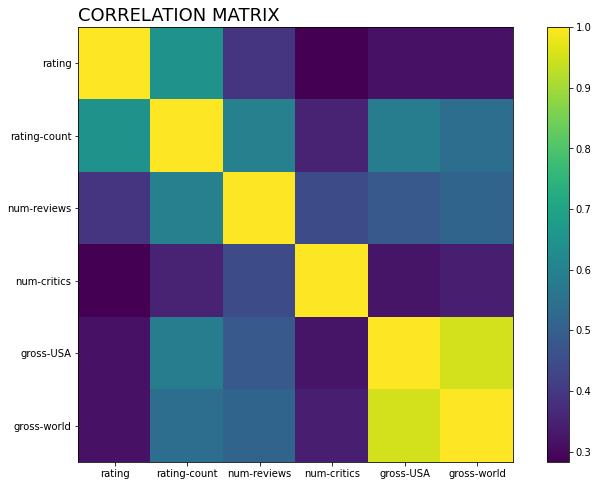

In [7]:
# FUNCTION FOR PEARSON AND SPEARMAN CORRELATION
def calculate_cov(x, y):
    return np.mean(x*y) - np.mean(x) * np.mean(y)

def calculate_pearson_corr(x, y):
    cov = calculate_cov(x, y) # covariance of x and y
    return cov / (np.std(x) * np.std(y))

def calculate_rank(x, y):
    r_x = x.argsort()[::-1] # calculate rank x
    r_y = y.argsort()[::-1]
    return r_x + 1, r_y + 1

def calculate_spearman_corr(x, y):
    n = len(x)
    r_x, r_y = calcuate_rank(x, y)
    d = [ abs(r_x[i] - r_y[i]) for i in range(n) ]
    d_sqr = np.array([i*i for x in d])
    s = 6 * np.sum(d_sqr)
    r = n * (n*n -1)
    return 1 - (s/r)

# calculate pearson's correlation and plot heatmap
newdf = df.copy()
for col in columns[2:]:
    newdf = newdf[newdf[col].notna()]
attrs = np.transpose((newdf[columns[2:]].copy()).values)
matrix_corr = np.zeros((len(attrs), len(attrs)))
for i in range(len(attrs)):
    for j in range(len(attrs)):
        matrix_corr[i, j] = calculate_pearson_corr(attrs[i], attrs[j])
# # ax.set_yticklabels(cols[3:])
# # ax.set_xticklabels(cols[3:])
# fig, ax = plt.subplots(figsize=(8, 4))
# # ax.plot(cols[3:], cols[3:])
# plt.imshow(matrix_corr, cmap='viridis')
# plt.colorbar()
# plt.show()
fig, ax = plt.subplots(figsize=(12, 8))
yticks = columns[2:]
xticks = columns[2:]
title = 'CORRELATION MATRIX'
plt.xticks(np.arange(6), columns[2:])
plt.yticks(np.arange(6), columns[2:])
plt.title(title, loc='left', fontsize=18)
plt.imshow(matrix_corr, cmap='viridis')
plt.colorbar()
plt.show()

# Bayes classication

Accuracy score: 0.72

f1 score: 0.7586206896551724

Confusion matrix:


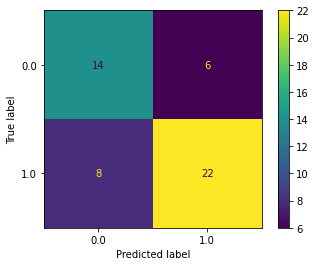

In [8]:
traindf = df[columns[2:]]
# {‘backfill’, ‘bfill’, ‘pad’, ‘ffill’,
traindf = traindf.fillna(axis=0, method='bfill')
X = np.array(traindf[columns[3:]].copy())
y = np.array(traindf['rating'].copy())
# LABELING DATA
y[y < 5 ] = 0
y[y >= 5] = 1
# SPLIT DATA TO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30)
# TRAIN
clf = MultinomialNB()
clf.fit(X_train, y_train)
# PREDICT AND EVALUATION
y_pred = clf.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print(f'\nf1 score: {f1_score(y_test, y_pred)}')
print(f'\nConfusion matrix:')
plot_confusion_matrix(clf, X_test, y_test)
plt.show()

# Apriori Algorithms

In [114]:
# FUNCTION FOR APRIORI ALGORITHMS
def calculate_frequent(data, c):
    for key in c[-1]:
        for row in data:
            if isinstance(key, str):
                if key in row:
                    c[-1][key] += 1
            else:
                flag = True
                for e in list(key):
                    if e not in row:
                        flag = False
                        break
                if flag:
                    c[-1][key] += 1

def get_frequent(c, l, ms):
    containers = {}
    for key, value in c[-1].items():
        if value > ms:
            containers[key] = value
    return l.append(containers)

def generate_candidates(l):
    newl = list(l[-1].keys())
    containers = []
    for i in range(len(newl)):
        for j in range(i+1, len(newl)):
            if isinstance(newl[i], str):
                if newl[i] != newl[j]:
                    containers.append([newl[i], newl[j]])
            else:
                newl = [list(e) for e in newl]
                if newl[i][:-1] == newl[j][:-1] and newl[i][-1] != newl[j][-1]:
                    temp = newl[i].copy()
                    temp.append(newl[j][-1])
                    containers.append(temp)
    return { tuple(key) : 0 for key in containers if has_infrequent_subset(key, l) == False }

def has_infrequent_subset(candidate, l):
    newl = list(l[-1].keys())
    subsets = list(combinations(candidate, len(candidate)-1))
    for subset in subsets:
        if len(subset) < 2:
            if subset[0] not in newl:
                return True
        else:
            if subset not in newl:
                return True
    return False

def apriori(data, cates, min_sup, min_conf):
    ms = min_sup * len(data)
    print(f'Apriori algorithms with min support = {ms}:')
    c = []
    l = []
    counter = 0
    c.append({key : 0 for key in cates})
    while True:
        calculate_frequent(data, c)
        get_frequent(c, l, ms)
        if len(c[-1]) > 0 and len(l[-1]) >0:
            print(f'FREQUENT {counter+1}-ITEMSETS', end=' ')
            print('-------------------------------------------------------------------------------')
            for key, value in l[-1].items():
                if counter > 0:
                    print(f'{list(key)} - frequent = {value}')
                else:
                    print(f'[{key}] - frequent = {value}')
            counter+=1
        else:
            break
        c.append(generate_candidates(l))
#     print(l)
    generate_association_rule(l, min_conf)


def generate_association_rule(l, min_conf):
    print(F'\n\nASSOCIATION RULE WITH MIN CONFIDENCE = {min_conf}\n')
    for i in range(1, len(l)-1):
        itemset = [ list(t) for t in l[i].keys() ]
        for item in itemset:
            numerator = l[len(item)-1][tuple(item)]
            for num in range(1, len(item)):
                subset = [list(t) for t in combinations(item, num)]
                for sub in subset:
                    rem = [ t for t in item if t not in sub ]
                    if len(sub) > 1:
                        denominator = l[len(sub)-1][tuple(sub)]
                    else:
                        denominator = l[0][sub[0]]
                    conf = numerator / denominator
                    if conf >= min_conf:
                        print(f'{sub} => {rem}: {conf}')
#     print(f'Association rule with min_conf = {min_conf}')
# RUN APRIORI ALGORITHMS WITH GENRES MOVIE
temp = df['genres'].values
x = []
cates = []
for t in temp:
    cates.extend(t.split())
    x.append(t.split())
cates = list(set(cates))
cates.sort()
apriori(x, cates, min_sup=0.02, min_conf=0.3)

Apriori algorithms with min support = 10.0:
FREQUENT 1-ITEMSETS -------------------------------------------------------------------------------
[Action] - frequent = 130
[Adventure] - frequent = 122
[Animation] - frequent = 27
[Biography] - frequent = 27
[Comedy] - frequent = 163
[Crime] - frequent = 91
[Drama] - frequent = 225
[Family] - frequent = 45
[Fantasy] - frequent = 47
[History] - frequent = 14
[Horror] - frequent = 66
[Mystery] - frequent = 59
[Romance] - frequent = 51
[Sci-Fi] - frequent = 58
[Sport] - frequent = 13
[Thriller] - frequent = 78
[War] - frequent = 21
FREQUENT 2-ITEMSETS -------------------------------------------------------------------------------
['Action', 'Adventure'] - frequent = 63
['Action', 'Comedy'] - frequent = 31
['Action', 'Crime'] - frequent = 26
['Action', 'Drama'] - frequent = 28
['Action', 'Fantasy'] - frequent = 19
['Action', 'Sci-Fi'] - frequent = 34
['Action', 'Thriller'] - frequent = 12
['Adventure', 'Animation'] - frequent = 22
['Adventure'

# FP-Growth

In [115]:
class Node:
    def __init__(self, name, number, parent):
        self.name = name
        self.item_count = number
        self.nodeLink = None
        self.parent = parent
        self.children = {}

    def inc(self, number):
        self.item_count += number

    def disp(self, ind=1):
        print(' ' * ind, self.name, ' ', self.item_count)
        for child in self.children.keys():
            child.disp(ind + 1)


class FPTree:
    def __init__(self, data, min_sup=10):
        self.data = data
        self.min_sup = min_sup

        # create null root
        self.root = Node('Null', 1, None)

        # dictionary containing items and the support count
        self.item_sup = {}

        # dictionary containing items more than the minsupport count and sorted decs order
        self.item_sort_dict = []
        self.item_index_dict = {}  # used to indexing item
        self.header_table = []

        # list of transactions are sorted
        self.trans_sorted_item = []

        #list of transtions are pruned by minsup
        self.trans_pruned_item = []
        
        self.result = []

        self.construct(data)
    
#     def cal_freq(self, data):
#         temp = {}
#         for transaction in data:
#             for item in transaction:
#                 temp[item] += 1
#         for key, value in temp.items():
#             if value >= min_sup:
#                 self.result.append([set(key), value])

    # this function is used to clean data and create a fp-tree
    def construct(self, data):
        for transaction in data:
            for item in transaction:
                if item in self.item_sup:
                    self.item_sup[item] += 1
                else:
                    self.item_sup[item] = 1
#         if len(self.result) < 1:
#             print('chay 1 lan thoi dcm')
#             for key, value in self.item_sup.items():
#                 print(key, value)
#                 self.result.append([set(key), value])
        self.list_item = list(self.item_sup.keys())

        # prune all item with min_sup
        for item in self.list_item:
            if self.item_sup[item] < self.min_sup:
                del self.item_sup[item]

        self.item_sort_dict = sorted(self.item_sup.items(), key=lambda x: (-x[1], x[0]))

        for trans in self.data:
            temp = [item for item in trans if item in self.item_sup.keys()]
            if len(temp) != 0:
                self.trans_pruned_item.append(temp)
        t = 0
        for item in self.item_sort_dict:
            name = item[0]
            count = item[1]
            self.item_index_dict[name] = t
            t += 1
            item_info = {'item_name': name, 'item_count': count, 'link_node': None}
            self.header_table.append(item_info)

        for trans in self.trans_pruned_item:
            # sorted item by frequency of each item and sort by alphabet
            trans_sort = sorted(trans, key=lambda x: self.item_index_dict[x])
            self.trans_sorted_item.append(trans_sort)
        # insert item to the fp tree

        for trans in self.trans_sorted_item:
            R = self.root
            for item in trans:
                if item in R.children.keys():
                    R.children[item].inc(1)
                    R = R.children[item]
                else:
                    R.children[item] = Node(name=item, number=1, parent=R)
                    R = R.children[item]

                    for item_info in self.header_table:
                        if item_info["item_name"] == R.name:
                            if item_info["link_node"] is None:
                                item_info["link_node"] = R
                            else:
                                iter_node = item_info["link_node"]
                                while iter_node.nodeLink is not None:
                                    iter_node = iter_node.nodeLink
                                iter_node.nodeLink = R

    # this function is used to create a conditional pattern base
    def trans_cond_tree(self, N):
        if N.parent is None:
            return None

        cond_tree_line = []

        while N is not None:
            line = []
            parentNode = N.parent

            while parentNode.parent is not None:
                line.append(parentNode.name)
                parentNode = parentNode.parent

            line = line[::-1]
            for i in range(N.item_count):
                cond_tree_line.append(line)
            N = N.nodeLink
        return cond_tree_line

    #find frequent itemset
    def find_frequent(self, parentNode=None):
        if len(list(self.root.children.keys())) == 0:
            return None

        min_sup = self.min_sup
        result = []
#         result.extend(self.result)
        #starting from the end of header table
        retrieve_table = self.header_table[::-1]
        for n in retrieve_table:
            fq_set = [set(), 0]
            if parentNode is None:
                fq_set[0] = {n['item_name'],}
            else:
                fq_set[0] = {n['item_name']}.union(parentNode[0])
            fq_set[1] = n['item_count']
            result.append(fq_set)
            cond_tran = self.trans_cond_tree(n['link_node'])
            #recursively build the conditional fp tree
            contree = FPTree(cond_tran, min_sup)
            conitems = contree.find_frequent(fq_set)
            if conitems is not None:
                for item in conitems:
                    result.append(item)
        return result

In [122]:
temp = df['genres'].values
x = []
cates = []
for t in temp:
    cates.extend(t.split())
    x.append(t.split())
cates = list(set(cates))
cates.sort()
min_support = 0.02 * len(x)
tree = FPTree(x, min_sup=min_support)
fq_itemset = tree.find_frequent()
# print(fq_itemset)
# fq_itemset = [[item[0] for item in fq_itemset if len(item[0]) > 1]
# fq_itemset = [list(item[0], item[1]) for item in fq_itemset]
# print(fq_itemset)
print(f'FP-Growth algorithms with min support = {min_support}')
frequent_itemset = [[list(item[0]), item[1]] for item in fq_itemset]
# i = 1
fp_l = []
i = 1
# print(frequent_itemset)
while True:
    c = {}
    ith_freq_itemset = [t for t in frequent_itemset if len(t[0]) == i]
    if len(ith_freq_itemset) == 0:
        break
    print(f'FREQUENT {i}-ITEMSETS', end=' ')
    print('-------------------------------------------------------------------------------')
    for e in ith_freq_itemset:
        if i == 1:
            c.update({e[0][0]: e[1]})
        else:
            temp = sorted(e[0])
            c.update({tuple(temp): e[1]})
        print(f'{e[0]} - frequent = {e[1]}')
    i+=1
    fp_l.append(c)
fp_l.append({})
generate_association_rule(fp_l, min_conf=0.3)

FP-Growth algorithms with min support = 10.0
FREQUENT 1-ITEMSETS -------------------------------------------------------------------------------
['Sport'] - frequent = 13
['History'] - frequent = 14
['War'] - frequent = 21
['Biography'] - frequent = 27
['Animation'] - frequent = 27
['Family'] - frequent = 45
['Fantasy'] - frequent = 47
['Romance'] - frequent = 51
['Sci-Fi'] - frequent = 58
['Mystery'] - frequent = 59
['Horror'] - frequent = 66
['Thriller'] - frequent = 78
['Crime'] - frequent = 91
['Adventure'] - frequent = 122
['Action'] - frequent = 130
['Comedy'] - frequent = 163
['Drama'] - frequent = 225
FREQUENT 2-ITEMSETS -------------------------------------------------------------------------------
['Biography', 'History'] - frequent = 10
['Drama', 'History'] - frequent = 14
['Drama', 'War'] - frequent = 20
['Biography', 'Drama'] - frequent = 27
['Animation', 'Comedy'] - frequent = 15
['Adventure', 'Animation'] - frequent = 22
['Family', 'Drama'] - frequent = 10
['Family', 'Fa